In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. 加载数据
df = pd.read_csv('sales_data.csv')

In [2]:
# 2. 缺失值填充
# 假设Product_Category_2和Product_Category_3的缺失值用 - 1填充
df['Product_Category_2'] = df['Product_Category_2'].fillna(-1)
df['Product_Category_3'] = df['Product_Category_3'].fillna(-1)

In [3]:
# 3. 类别编码
# 性别（Gender）
gender_encoder = OneHotEncoder(sparse_output=False)
gender_encoded = gender_encoder.fit_transform(df[['Gender']])
gender_df = pd.DataFrame(gender_encoded, columns=gender_encoder.get_feature_names_out(['Gender']))
df = pd.concat([df.drop('Gender', axis=1), gender_df], axis=1)

# 年龄（Age）
age_mapping = {'0-17': 0, '18-25': 1, '26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}
df['Age'] = df['Age'].map(age_mapping)

# 城市类别（City_Category）
city_encoder = OneHotEncoder(sparse_output=False)
city_encoded = city_encoder.fit_transform(df[['City_Category']])
city_df = pd.DataFrame(city_encoded, columns=city_encoder.get_feature_names_out(['City_Category']))
df = pd.concat([df.drop('City_Category', axis=1), city_df], axis=1)

# 在当前城市居住年限（Stay_In_Current_City_Years）
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].replace('4+', 4).astype(int)

In [4]:
# 4. 标准化
# 对Purchase进行标准化
scaler = StandardScaler()
df[['Purchase']] = scaler.fit_transform(df[['Purchase']])

print(df.head())

   User_ID Product_ID  Age  Occupation  Stay_In_Current_City_Years  \
0  1000001  P00069042    0          10                           2   
1  1000001  P00248942    0          10                           2   
2  1000001  P00087842    0          10                           2   
3  1000001  P00085442    0          10                           2   
4  1000002  P00285442    6          16                           4   

   Marital_Status  Product_Category_1  Product_Category_2  Product_Category_3  \
0               0                   3                -1.0                -1.0   
1               0                   1                 6.0                14.0   
2               0                  12                -1.0                -1.0   
3               0                  12                14.0                -1.0   
4               0                   8                -1.0                -1.0   

   Purchase  Gender_F  Gender_M  City_Category_A  City_Category_B  \
0 -0.193507       1.0  

In [5]:
# 分类/回归与聚类分析完整实现
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score,
                             silhouette_score,
                             mean_squared_error,
                             r2_score)

# 数据准备（基于预处理后的数据）
# 定义特征列（排除ID和已处理列）
feature_cols = ['Age', 'Occupation', 'Stay_In_Current_City_Years', 'Marital_Status',
                'Product_Category_1', 'Product_Category_2', 'Product_Category_3',
                'Gender_F', 'Gender_M', 'City_Category_A', 'City_Category_B', 'City_Category_C']

# 方案一：分类任务（预测城市类别）
X = df[feature_cols]
y = df[['City_Category_A', 'City_Category_B', 'City_Category_C']].idxmax(axis=1)  # 还原原始城市类别

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 构建决策树分类器
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n城市分类结果：")
print(f"准确率: {accuracy_score(y_test, y_pred):.2f}")


城市分类结果：
准确率: 1.00


<Figure size 1000x600 with 0 Axes>

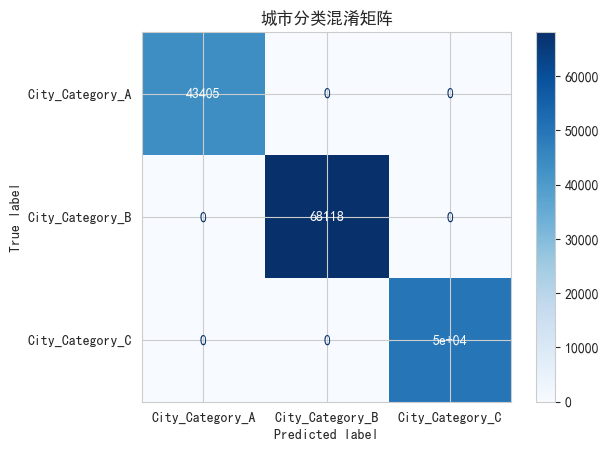

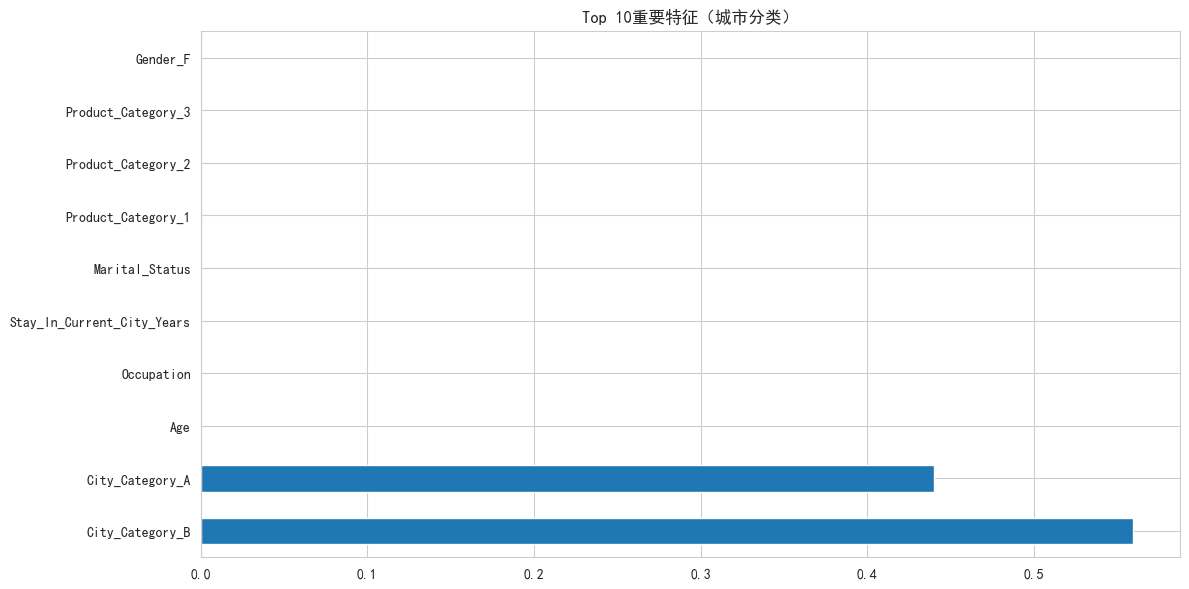

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置黑体作为默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示异常
# 可视化模块需要添加的库
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

# ---- 分类可视化 ----
plt.figure(figsize=(10,6))
# 混淆矩阵
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('城市分类混淆矩阵')

# 特征重要性
plt.figure(figsize=(12,6))
feat_importances = pd.Series(clf.feature_importances_, index=feature_cols)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10重要特征（城市分类）')
plt.tight_layout()

In [7]:
# 方案二：回归任务（预测购买金额）
scaler = StandardScaler()
X_reg = df[feature_cols]
y_reg = scaler.fit_transform(df[['Purchase']]).flatten()  # 标准化目标变量

# 拆分数据集
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# 构建决策树回归器
reg = DecisionTreeRegressor(max_depth=5, random_state=42)
reg.fit(X_train_reg, y_train_reg)
y_pred_reg = reg.predict(X_test_reg)

print("\n购买金额回归结果：")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_reg):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_reg):.2f}")


购买金额回归结果：
MSE: 0.51
R²: 0.49


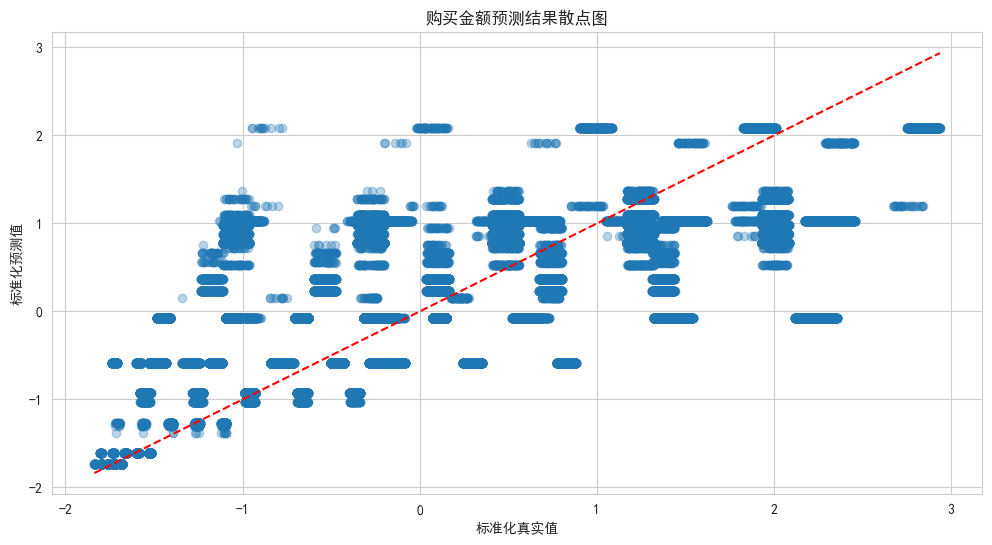

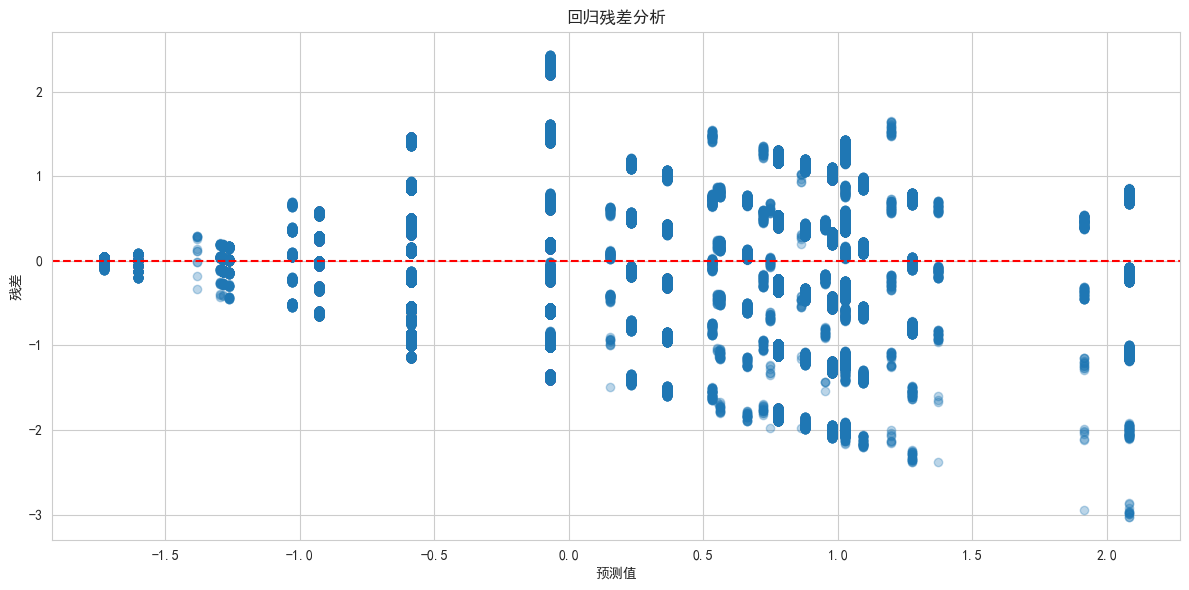

In [8]:
# ---- 回归可视化 ----
plt.figure(figsize=(12,6))
# 预测值与真实值散点图
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)
plt.plot([min(y_test_reg), max(y_test_reg)],
         [min(y_test_reg), max(y_test_reg)], 'r--')
plt.xlabel('标准化真实值')
plt.ylabel('标准化预测值')
plt.title('购买金额预测结果散点图')

# 残差图
plt.figure(figsize=(12,6))
residuals = y_test_reg - y_pred_reg
plt.scatter(y_pred_reg, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('预测值')
plt.ylabel('残差')
plt.title('回归残差分析')
plt.tight_layout()

In [9]:
# 方案三：聚类分析（客户分群）
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df[feature_cols])

# 使用MiniBatchKMeans替代标准KMeans
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=3,
                        random_state=42,
                        batch_size=1000,  # 根据数据量调整
                        max_iter=300)
clusters = kmeans.fit_predict(X_cluster)

# 抽样计算轮廓系数（针对大数据集）
from sklearn.utils import resample
sample_data = resample(X_cluster,
                      n_samples=min(1000, X_cluster.shape[0]),
                      random_state=42)
print(f"轮廓系数: {silhouette_score(sample_data, kmeans.predict(sample_data)):.2f}")

轮廓系数: 0.16


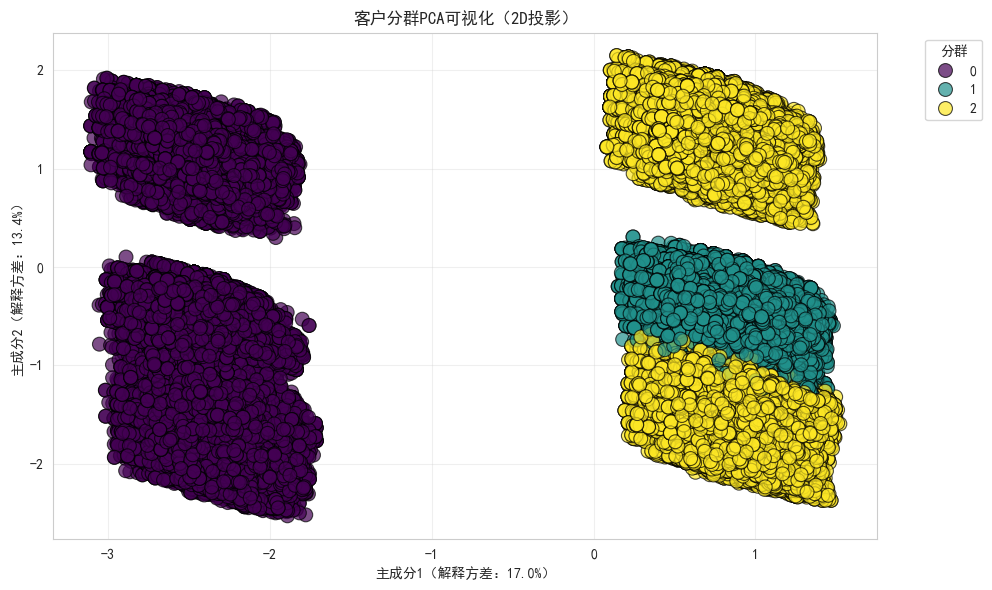

In [10]:
import numpy as np

# ---- 聚类可视化优化 ----
# 添加聚类标签到数据集
df['Cluster'] = clusters  # 确保添加聚类标签列

# 1. PCA降维可视化
plt.figure(figsize=(10,6))
pca = PCA(n_components=2)
cluster_2d = pca.fit_transform(X_cluster)

# 绘制主成分散点图
sns.scatterplot(x=cluster_2d[:,0], y=cluster_2d[:,1],
                hue=clusters, palette='viridis',
                alpha=0.7, s=100, edgecolor='k')
plt.title('客户分群PCA可视化（2D投影）')
plt.xlabel('主成分1（解释方差：{:.1%}）'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('主成分2（解释方差：{:.1%}）'.format(pca.explained_variance_ratio_[1]))
plt.legend(title='分群', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

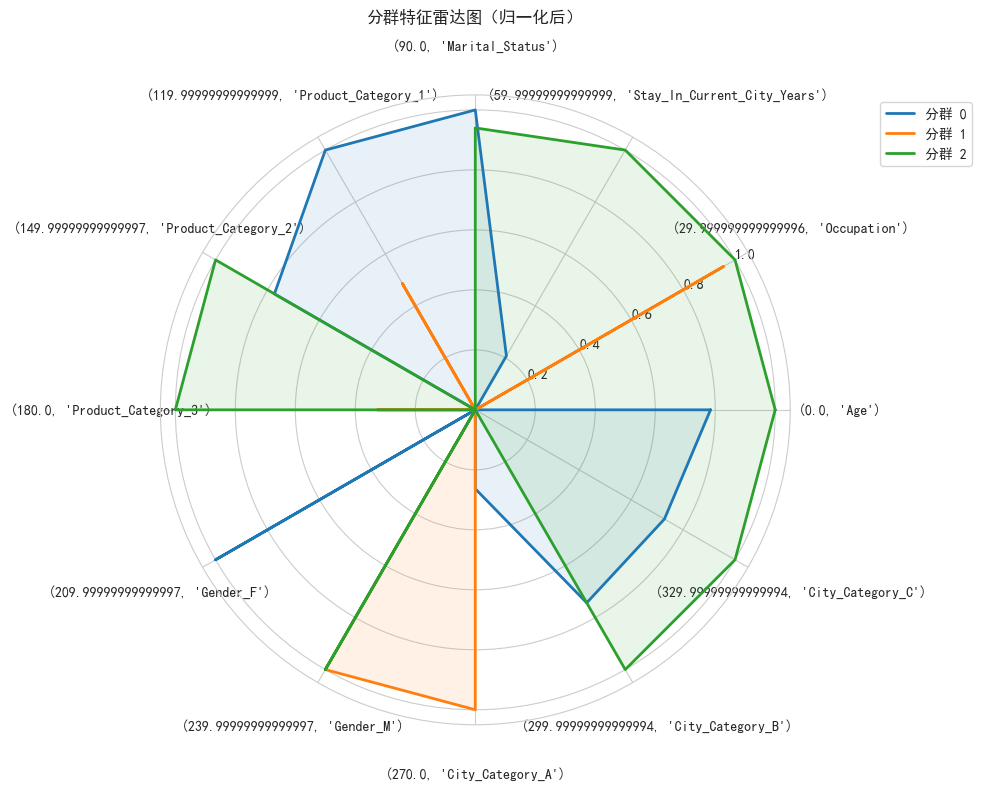

In [11]:
# 2. 特征雷达图优化
def radar_label_adjust(angles, labels):
    """调整雷达图标签位置"""
    return [(angle*180/np.pi, label) for angle, label in zip(angles[:-1], labels)]

# 计算分群特征均值
cluster_means = df.groupby('Cluster')[feature_cols].mean()

# 特征归一化处理（逐特征归一化）
max_values = cluster_means.max()
min_values = cluster_means.min()
normalized = (cluster_means - min_values) / (max_values - min_values).replace(0, 1)  # 防止除以零

# 创建雷达图
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, polar=True)
categories = normalized.columns
N = len(categories)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

# 绘制各分群雷达图
for idx in normalized.index:
    values = normalized.loc[idx].values.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2,
            label=f'分群 {idx}', linestyle='solid')
    ax.fill(angles, values, alpha=0.1)

# 设置雷达图标签和格式
ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_label_adjust(angles, categories))
ax.tick_params(axis='x', pad=25)  # 调整标签间距
ax.set_rlabel_position(30)
plt.title('分群特征雷达图（归一化后）', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()


模型性能对比：
决策树准确率: 1.00
Adaboost准确率: 1.00
随机森林准确率: 1.00


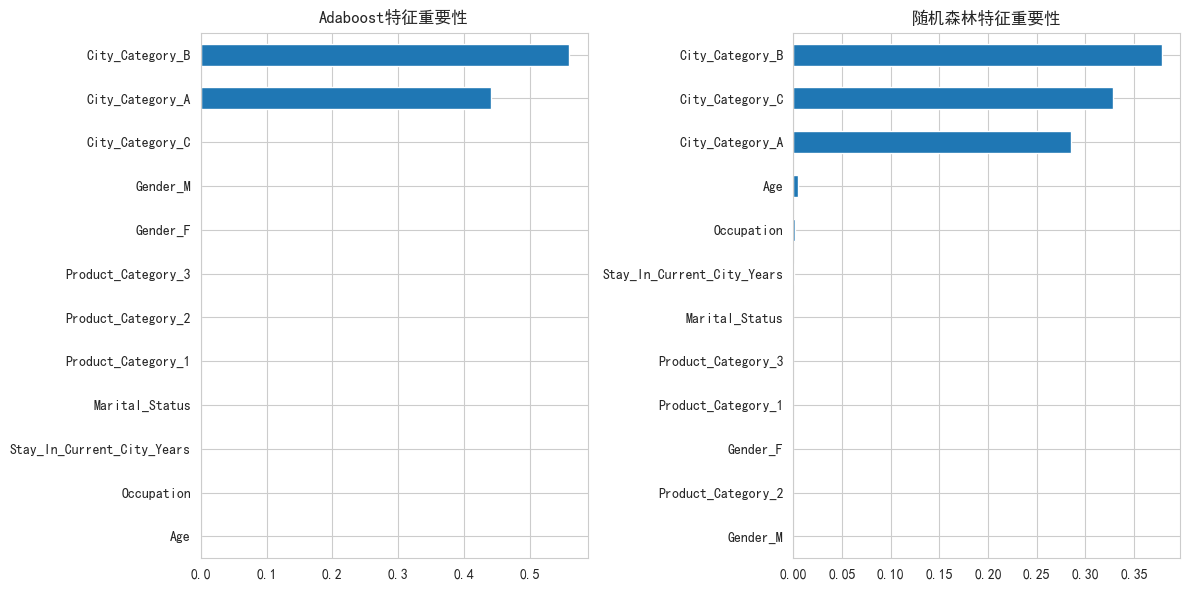

In [12]:
# ========== 集成学习实现 ==========
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# 数据准备（复用已有特征工程）
X = df[feature_cols]
y = df[['City_Category_A', 'City_Category_B', 'City_Category_C']].idxmax(axis=1)

# 拆分数据集（保持与之前相同的随机状态）
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

# 基准模型（决策树）
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train, y_train)
dt_score = dt_clf.score(X_test, y_test)

# Adaboost（基于决策树）
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=50,
    learning_rate=0.8,
    algorithm='SAMME',  # 显式指定算法
    random_state=42
)
ada.fit(X_train, y_train)
ada_score = ada.score(X_test, y_test)

# 随机森林
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    random_state=42
)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)

# 模型性能对比
print("\n模型性能对比：")
print(f"决策树准确率: {dt_score:.2f}")
print(f"Adaboost准确率: {ada_score:.2f}")
print(f"随机森林准确率: {rf_score:.2f}")

# 特征重要性分析
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
pd.Series(ada.feature_importances_, index=feature_cols).sort_values().plot.barh()
plt.title('Adaboost特征重要性')

plt.subplot(1, 2, 2)
pd.Series(rf.feature_importances_, index=feature_cols).sort_values().plot.barh()
plt.title('随机森林特征重要性')
plt.tight_layout()

In [13]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# 假设你已经定义好了 X_train 和 feature_cols
# 示例 feature_cols = ['Age', 'Income', 'Purchase_Frequency']

class CustomerSegmenter:
    def __init__(self, n_clusters=3, batch_size=1024):
        self.n_clusters = n_clusters
        # 使用 MiniBatchKMeans 提高训练速度
        self.model = MiniBatchKMeans(n_clusters=n_clusters,
                                     batch_size=batch_size,
                                     random_state=42)

    def fit_predict(self, X):
        """
        返回原始数据加上 cluster 标签的新 DataFrame
        """
        if isinstance(X, pd.DataFrame):
            X_np = X.values
        else:
            X_np = X

        clusters = self.model.fit_predict(X_np)
        # 将聚类结果添加为新列（不修改原数据）
        if isinstance(X, pd.DataFrame):
            X_with_cluster = X.copy()
            X_with_cluster['cluster'] = clusters
        else:
            X_with_cluster = np.column_stack((X_np, clusters))
        return X_with_cluster, clusters

    def evaluate(self, X):
        """
        计算轮廓系数评估聚类效果
        """
        if isinstance(X, pd.DataFrame):
            X_np = X.values
        else:
            X_np = X
        return silhouette_score(X_np, self.model.labels_)


# 示例用法
if __name__ == "__main__":
    # 模拟数据
    from sklearn.datasets import make_blobs
    X, y = make_blobs(n_samples=10000, n_features=5, centers=4, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    segmenter = CustomerSegmenter(n_clusters=4)
    X_train_clustered, clusters = segmenter.fit_predict(X_train)

    print(f"轮廓系数: {segmenter.evaluate(X_train):.2f}")


轮廓系数: 0.74


In [ ]:
from sklearn.model_selection import GridSearchCV
# 追加模块：Adaboost集成
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

class AdaBoostWrapper:
    def __init__(self, estimator=None, n_estimators=50):
        self.model = AdaBoostClassifier(
            estimator=estimator,
            n_estimators=n_estimators,
            algorithm="SAMME",  # 显式指定使用 SAMME 算法
            random_state=42
        )

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def optimize(self, X_train, y_train):
        param_grid = {
            'n_estimators': [50, 100],
            'learning_rate': [0.5, 1.0]
        }
        grid_search = GridSearchCV(self.model, param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        self.model = grid_search.best_estimator_
        return grid_search.best_params_

# 示例使用
adaboost = AdaBoostWrapper(estimator=DecisionTreeClassifier(max_depth=1))
best_params = adaboost.optimize(X_train, y_train)
y_pred_ada = adaboost.predict(X_test)


In [ ]:
from sklearn.model_selection import GridSearchCV
# 追加模块：Adaboost集成
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

class AdaBoostWrapper:
    def __init__(self, estimator=None, n_estimators=50):
        self.model = AdaBoostClassifier(
            estimator=estimator,
            n_estimators=n_estimators,
            algorithm="SAMME",  # 显式指定使用 SAMME 算法
            random_state=42
        )

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def optimize(self, X_train, y_train):
        param_grid = {
            'n_estimators': [50, 100],
            'learning_rate': [0.5, 1.0]
        }
        grid_search = GridSearchCV(self.model, param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        self.model = grid_search.best_estimator_
        return grid_search.best_params_

# 示例使用
adaboost = AdaBoostWrapper(estimator=DecisionTreeClassifier(max_depth=1))
best_params = adaboost.optimize(X_train, y_train)
y_pred_ada = adaboost.predict(X_test)


In [ ]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor


# 模块2：模型训练器
class ModelTrainer:
    def __init__(self, model_type='classification'):
        self.model_type = model_type
        self.models = {
            'rf': RandomForestClassifier() if model_type == 'classification'
                   else RandomForestRegressor(),
            'ada': AdaBoostClassifier() if model_type == 'classification'
                   else AdaBoostRegressor()
        }

    def train(self, X_train, y_train):
        # 添加交叉验证训练逻辑
        trained_models = {}
        for name, model in self.models.items():
            model.fit(X_train, y_train)
            trained_models[name] = model
        return trained_models

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score


# 模块3：评估分析器
class ModelEvaluator:
    @staticmethod
    def evaluate_classification(y_true, y_pred):
        metrics = {
            'Accuracy': accuracy_score(y_true, y_pred),
            'F1': f1_score(y_true, y_pred),
            'ROC AUC': roc_auc_score(y_true, y_pred)
        }
        return pd.DataFrame([metrics])

    @staticmethod
    def explain_model(model, features):
        # 添加SHAP解释
        import shap
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(features)
        shap.summary_plot(shap_values, features)

In [ ]:
from sklearn.base import ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV


# 高级参数调优模块
class HyperparameterOptimizer:
    def __init__(self, model, param_grid):
        self.model = model
        self.param_grid = param_grid

    def optimize(self, X, y, cv=5):
        search = RandomizedSearchCV(
            self.model,
            self.param_grid,
            n_iter=20,
            cv=cv,
            scoring='accuracy' if isinstance(self.model, ClassifierMixin) else 'r2',
            random_state=42
        )
        search.fit(X, y)
        return search.best_estimator_

# 随机森林参数空间示例
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'bootstrap': [True, False]
}

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 df 是已经加载好的 DataFrame
# 示例数据列名 ['User_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Purchase']

# 特征列（数值型）
feature_cols = ['Purchase', 'Age', 'Occupation', 'Stay_In_Current_City_Years']

# --- 分类任务：预测城市类别 (City_Category) ---
X_clf = df[feature_cols]
y_clf = df['City_Category']  # 正确的分类标签（不是 Age）

# 拆分数据集
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

# 定义分类模型和参数空间
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

param_grid = {
    'DecisionTree': {'max_depth': [3, 5]},
    'RandomForest': {'n_estimators': [50, 100], 'max_depth': [3, 5]},
    'SVM': {'C': [0.1, 1], 'kernel': ['linear']}
}

In [ ]:
# --- 分类模型训练与调参 ---
print("开始分类模型训练...")
best_models = {}

for name, model in models.items():
    print(f"正在训练 {name} ...")
    gs = RandomizedSearchCV(model,
                            param_grid[name],
                            n_iter=3,  # 减少搜索次数加快训练
                            cv=3,     # 减少交叉验证轮次
                            scoring='accuracy',
                            n_jobs=-1,
                            random_state=42)
    gs.fit(X_train_clf, y_train_clf)
    best_model = gs.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(X_test_clf)
    acc = accuracy_score(y_test_clf, y_pred)
    print(f"{name} 最佳参数: {gs.best_params_}")
    print(f"{name} 准确率: {acc:.2%}")

In [ ]:
# --- 回归任务：预测 Purchase（购买金额） ---
X_reg = df.drop(columns=['Purchase'])  # 所有特征
X_reg = pd.get_dummies(X_reg, drop_first=True)  # 对类别特征做独热编码
y_reg = df['Purchase'].values  # 目标变量

# 数据标准化
scaler = StandardScaler()
X_reg_scaled = scaler.fit_transform(X_reg)

# 拆分回归数据集
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_scaled, y_reg, test_size=0.3, random_state=42
)

# 构建回归模型
reg = DecisionTreeRegressor(max_depth=5, random_state=42)
reg.fit(X_train_reg, y_train_reg)
y_pred_reg = reg.predict(X_test_reg)

# 输出回归评估指标
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
print("\n【购买金额回归结果】")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

In [ ]:
# --- 可视化：混淆矩阵 + 特征重要性 ---

# 混淆矩阵
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test_clf, best_models['RandomForest'].predict(X_test_clf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test_clf))
disp.plot(cmap=plt.cm.Blues)
plt.title('城市分类混淆矩阵')
plt.show()

In [ ]:
# 特征重要性（以随机森林为例）
if 'RandomForest' in best_models:
    feat_importances = pd.Series(best_models['RandomForest'].feature_importances_,
                                 index=X_train_clf.columns)
    feat_importances.nlargest(10).plot(kind='barh', title='Top 10 重要特征（城市分类）')
    plt.tight_layout()
    plt.show()